# Importando Bibliotecas

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Funções Auxiliares

In [18]:
def dataFrame_to_boxPlot(dataFrame,var):
    data = {}
    column_value = []
    column_x = []

    for column in range(len(dataFrame.columns)):
        column_value += list(dataFrame.iloc[:,column])
        column_x += [f'x{column+1}' for i in range(len(dataFrame))]

    data[var]=column_value
    data['x']=column_x
    return pd.DataFrame(data)

In [19]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

In [20]:
def describe_dist_var(dataframe_1,dataframe_2,var):
    distancias_var = {}
        
    for periodo in range(52):
        aux = []
        for list_1 in dataframe_1[var]:
            for list_2 in dataframe_2[var]:
                aux.append(math.fabs(list_1[periodo]-list_2[periodo]))
        distancias_var[f'x{periodo+1}'] = aux

    return pd.DataFrame(distancias_var)

# Importando Dados

In [21]:
past = 'C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Previsoes/'

In [22]:
previsoes_np = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()


,demandas
0,"[9594.341796875, 9600.9443359375, 9612.6279296..."
1,"[9593.4462890625, 9599.9599609375, 9611.585937..."
2,"[9593.54296875, 9599.8740234375, 9619.23730468..."


In [23]:
previsoes_sar = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_sar/Previsao_sar{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_sar['demandas'] = previsoes
previsoes_sar = pd.DataFrame(previsoes_sar)

In [24]:
demandas_treino = pd.read_csv('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Demandas_treinamento/demandas')['demandas']
demandas_treino.head()

0    9557.259200
1    9626.838275
2    9631.554521
3    9625.125386
4    9661.327545
Name: demandas, dtype: float64

In [25]:
demandas = {}
demandas_aux = []
for i in range(0,int(len(demandas_treino)/52)):
    demandas_aux.append(list(demandas_treino[i*52:(i+1)*52].values))
demandas['demandas'] = demandas_aux
demandas = pd.DataFrame(demandas)

In [26]:
previsoes_sar

,demandas
0,"[9598.480825336552, 9599.815051218131, 9627.36..."
1,"[9598.480825336552, 9599.815051218131, 9627.36..."
2,"[9598.480825336552, 9599.815051218131, 9627.36..."


# Analise Das Previsões

In [27]:
previsao_demanda_np = describe_var(previsoes_np,'demandas')
previsao_demanda_sar = describe_var(previsoes_sar,'demandas')
demandas_d = describe_var(demandas,'demandas')

In [28]:
boxPlot_previsao_np = dataFrame_to_boxPlot(previsao_demanda_np,'demandas')
boxPlot_previsao_sar = dataFrame_to_boxPlot(previsao_demanda_sar,'demandas')
boxPlot_demandas = dataFrame_to_boxPlot(demandas_d,'demandas')

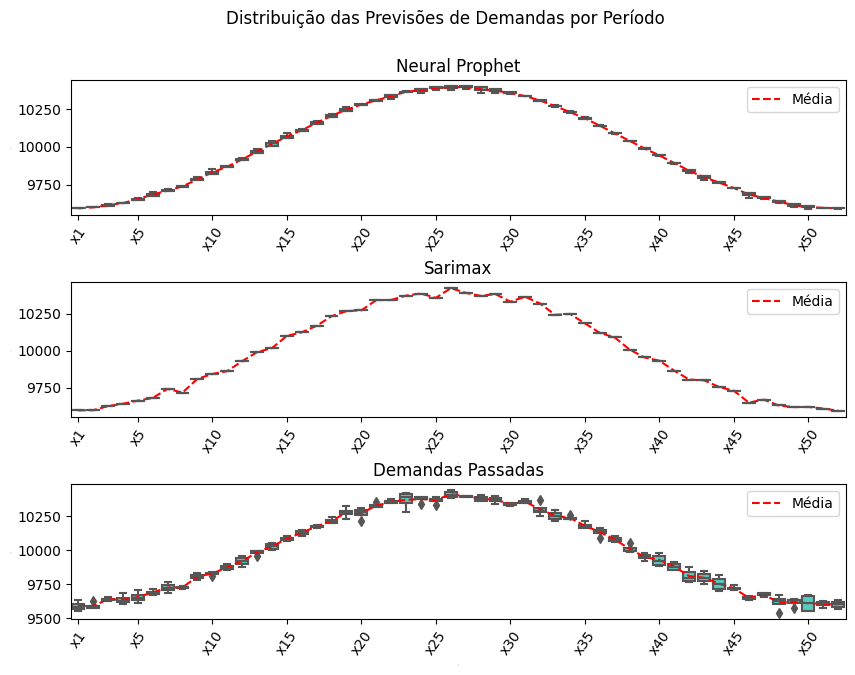

In [39]:
fig=plt.figure(figsize=(10,7))
fig.suptitle('Distribuição das Previsões de Demandas por Período')



plt.subplots_adjust(wspace=0, hspace=0.5)

ax=fig.add_subplot(3,1,1)
ax.set_title('Neural Prophet')
sns.boxplot(data=boxPlot_previsao_np,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_np.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_np.columns)/5)+1)])
plt.legend()


ax=fig.add_subplot(3,1,2)
ax.set_title('Sarimax')
sns.boxplot(data=boxPlot_previsao_sar,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_sar.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_sar.columns)/5)+1)])
plt.legend()


ax=fig.add_subplot(3,1,3)
ax.set_title('Demandas Passadas')
sns.boxplot(data=boxPlot_demandas,x='x',y='demandas',color='turquoise')
plt.plot(demandas_d.columns,demandas_d.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(demandas_d.columns)/5)+1)])
plt.legend()

([<matplotlib.axis.XTick at 0x1f1a7b77a00>,
 [Text(0, 0, 'x1'),
  Text(4, 0, 'x5'),
  Text(9, 0, 'x10'),
  Text(14, 0, 'x15'),
  Text(19, 0, 'x20'),
  Text(24, 0, 'x25'),
  Text(29, 0, 'x30'),
  Text(34, 0, 'x35'),
  Text(39, 0, 'x40'),
  Text(44, 0, 'x45'),
  Text(49, 0, 'x50')])

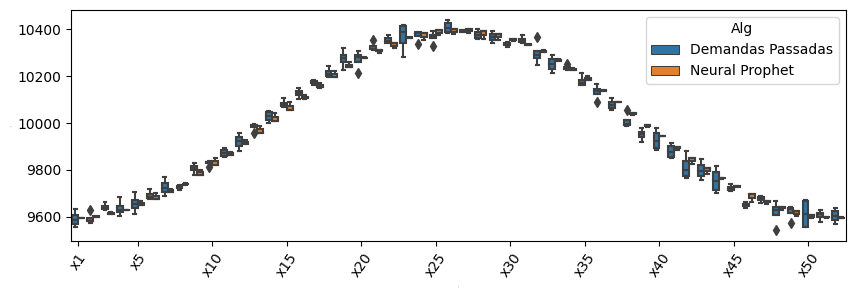

In [43]:
fig=plt.figure(figsize=(10,3))
a = pd.merge(boxPlot_demandas,boxPlot_previsao_np,how='outer')
a['Alg'] = ['Demandas Passadas' for i in range(len(boxPlot_demandas))]+['Neural Prophet' for i in range(len(boxPlot_previsao_np))]
ax = sns.boxplot(data=a,x='x',y='demandas',hue='Alg')
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
                 
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.xticks([0]+[i*5-1 for i in range(1,int(52/5)+1)])

([<matplotlib.axis.XTick at 0x1f1a545a800>,
 [Text(0, 0, 'x1'),
  Text(4, 0, 'x5'),
  Text(9, 0, 'x10'),
  Text(14, 0, 'x15'),
  Text(19, 0, 'x20'),
  Text(24, 0, 'x25'),
  Text(29, 0, 'x30'),
  Text(34, 0, 'x35'),
  Text(39, 0, 'x40'),
  Text(44, 0, 'x45'),
  Text(49, 0, 'x50')])

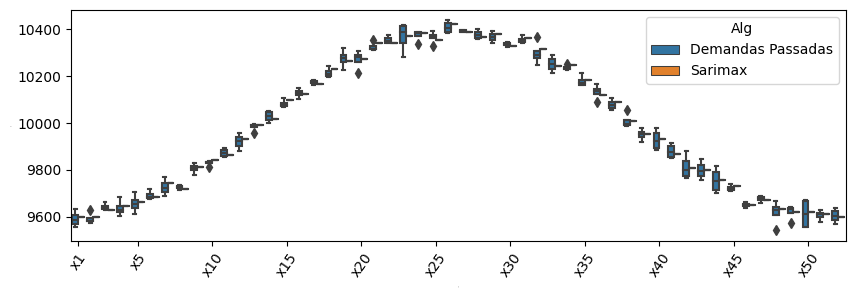

In [42]:
fig=plt.figure(figsize=(10,3))
a = pd.merge(boxPlot_demandas,boxPlot_previsao_sar,how='outer')
a['Alg'] = ['Demandas Passadas' for i in range(len(boxPlot_demandas))]+['Sarimax' for i in range(len(boxPlot_previsao_sar))]
ax = sns.boxplot(data=a,x='x',y='demandas',hue='Alg')
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
                 
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.xticks([0]+[i*5-1 for i in range(1,int(52/5)+1)])

In [31]:
dist_NS = describe_dist_var(previsoes_np,previsoes_sar,'demandas')
boxPlot_dist_NS = dataFrame_to_boxPlot(dist_NS,'dist')

dist_NT = describe_dist_var(previsoes_np,demandas,'demandas')
boxPlot_dist_NT = dataFrame_to_boxPlot(dist_NT,'dist')

dist_ST = describe_dist_var(previsoes_sar,demandas,'demandas')
boxPlot_dist_ST = dataFrame_to_boxPlot(dist_ST,'dist')

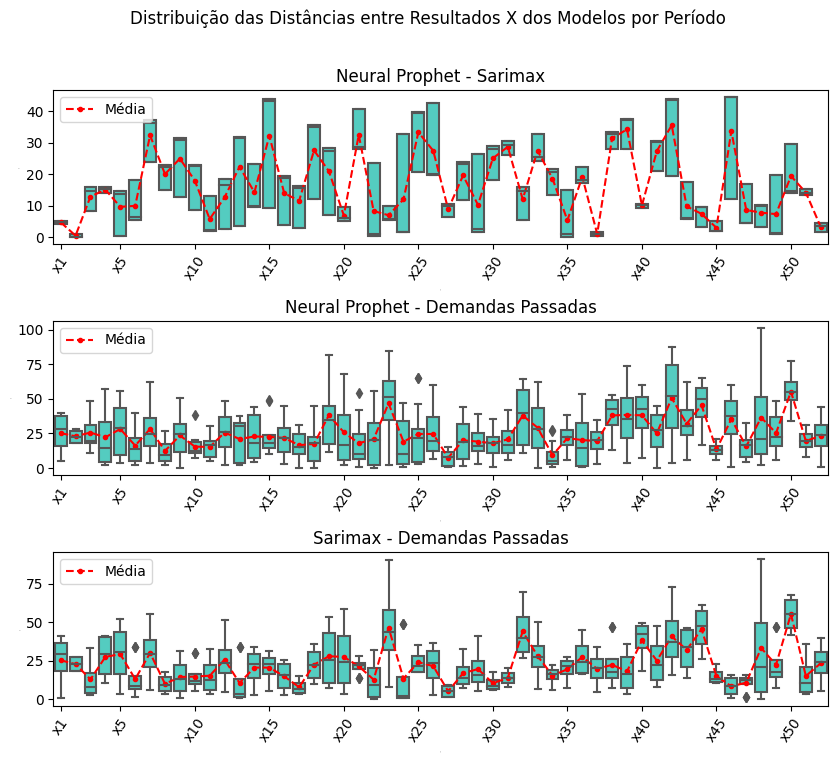

In [32]:
fig=plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0, hspace=0.5)
fig.suptitle('Distribuição das Distâncias entre Resultados X dos Modelos por Período')

ax=fig.add_subplot(3,1,1)
ax.set_title('Neural Prophet - Sarimax')
sns.boxplot(data=boxPlot_dist_NS,x='x',y='dist',color='turquoise')
plt.plot(dist_NS.columns,dist_NS.describe().iloc[1,:],color='red',marker='.',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(dist_NS.columns)/5)+1)])
plt.legend()

ax=fig.add_subplot(3,1,2)
ax.set_title('Neural Prophet - Demandas Passadas')
sns.boxplot(data=boxPlot_dist_NT,x='x',y='dist',color='turquoise')
plt.plot(dist_NT.columns,dist_NT.describe().iloc[1,:],color='red',marker='.',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(dist_NT.columns)/5)+1)])
plt.legend()

ax=fig.add_subplot(3,1,3)
ax.set_title('Sarimax - Demandas Passadas')
sns.boxplot(data=boxPlot_dist_ST,x='x',y='dist',color='turquoise')
plt.plot(dist_ST.columns,dist_ST.describe().iloc[1,:],color='red',marker='.',linestyle='--',label='Média')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(dist_ST.columns)/5)+1)])
plt.legend()

A diferença entre as previsões do Neural Prophet e Sarimax não passam de 200, e em sua maior parte não passam de 150 por período, oque pode-se considerar insignificante, considerando a grandeza da variável demanda. Contudo observe que essa diferença pode variar bastante oque é ociasionado pela variação das previsões do neural prophet, ja que sarimax não possue variação.

